In [28]:
import numpy as np
import pandas as pd
import warnings


from numba import  njit
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
from tqdm.notebook import tqdm


warnings.filterwarnings("ignore")

In [18]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

Task 1. Simulate a Cox-Ingersoll-Ross (CIR) model
$$
dX_t = (\theta_1 - \theta_2 X_t)dt + \theta_3 \sqrt{X_t}dW_t
$$
with $\theta = (6, 2, 1)$, and choose the bandwidth according to Scott’s rule and implement the non-parametric kernel estimation for stationary density of the CIR model.

Plot in a graph the true stationary density against the estimated one for two approaches
*  compute on the single trajectory  (set $T$ very large, time discretization step set as $T/N_t = \Delta t$);
*  compute on the Nx trajectories.




In [19]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

In [20]:
# approach 1

Nx = 1
Nt = 100000
T = 1000

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

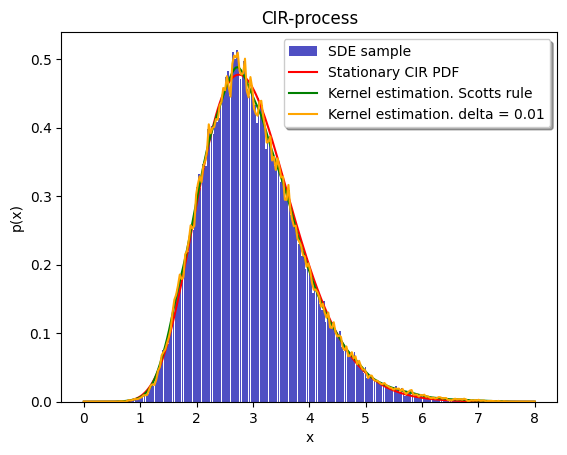

In [21]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR.flatten(), bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten()), label = f'Kernel estimation. Scotts rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten(), delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [22]:
# approach 2

Nx = 15000
Nt = 300

T = 1

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

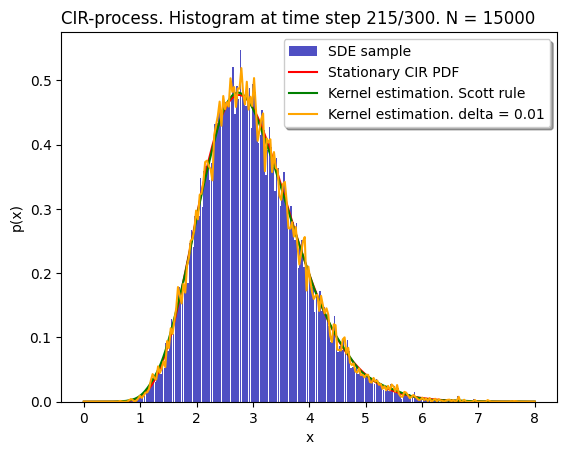

In [23]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

Task. Estimate the quality of the obtained approximations with statistical criteria and provide conclusions.

In [24]:
from scipy.stats import chisquare, bartlett, spearmanr, ks_2samp, anderson_ksamp, cramervonmises_2samp
from scipy import stats

In [25]:
stat_CIR_PDF = CIRp.StationaryDistribution(x_data)
stat_kernel_est_Scott_rule = StationaryDistributionKernelEstimator(x_data, x_data_CIR[i])
stat_kernel_est_delta = StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d)

# Функция chi для подготовки к Chi-квадрат тесту
def chi(data1, data2):
    num_bins = 10
    all_data = np.concatenate([data1, data2])
    bins = np.linspace(np.min(all_data), np.max(all_data), num_bins + 1)
    observed_freq, _ = np.histogram(data1, bins=bins)
    expected_freq, _ = np.histogram(data2, bins=bins)
    return observed_freq, expected_freq

# Подготовка данных для Chi-квадрат теста
observed_freq_scott, expected_freq_scott = chi(stat_CIR_PDF, stat_kernel_est_Scott_rule)
observed_freq_delta, expected_freq_delta = chi(stat_CIR_PDF, stat_kernel_est_delta)

# Chi-квадрат тест
chi2_stat_scott, p_value_scott = stats.chisquare(observed_freq_scott, expected_freq_scott)
chi2_stat_delta, p_value_delta = stats.chisquare(observed_freq_delta, expected_freq_delta)

# Kolmogorov-Smirnov тест
ks_2samp_scott = stats.ks_2samp(stat_CIR_PDF, stat_kernel_est_Scott_rule)
ks_2samp_delta = stats.ks_2samp(stat_CIR_PDF, stat_kernel_est_delta)

# Anderson-Darling тест
anderson_ksamp_scott = stats.anderson_ksamp([stat_CIR_PDF, stat_kernel_est_Scott_rule])
anderson_ksamp_delta = stats.anderson_ksamp([stat_CIR_PDF, stat_kernel_est_delta])

# Cramer-von Mises тест
cvm_scott = stats.cramervonmises_2samp(stat_CIR_PDF, stat_kernel_est_Scott_rule)
cvm_delta = stats.cramervonmises_2samp(stat_CIR_PDF, stat_kernel_est_delta)

# Spearman Correlation тест
spearman_scott = stats.spearmanr(stat_CIR_PDF, stat_kernel_est_Scott_rule)
spearman_delta = stats.spearmanr(stat_CIR_PDF, stat_kernel_est_delta)

# Bartlett тест на равенство дисперсий
bartlett_scott = stats.bartlett(stat_CIR_PDF, stat_kernel_est_Scott_rule)
bartlett_delta = stats.bartlett(stat_CIR_PDF, stat_kernel_est_delta)

# Компиляция всех результатов в единый DataFrame
results_df = pd.DataFrame({
    "Test": [
        "Chi-squared", "Kolmogorov-Smirnov", "Anderson-Darling",
        "Cramer-von Mises", "Spearman Correlation", "Bartlett Test"
    ],
    "Statistic (Scott)": [
        chi2_stat_scott, ks_2samp_scott.statistic, anderson_ksamp_scott.statistic,
        cvm_scott.statistic, spearman_scott.correlation, bartlett_scott.statistic
    ],
    "p-value (Scott)": [
        p_value_scott, ks_2samp_scott.pvalue, anderson_ksamp_scott.significance_level,
        cvm_scott.pvalue, spearman_scott.pvalue, bartlett_scott.pvalue
    ],
    "Statistic (Delta)": [
        chi2_stat_delta, ks_2samp_delta.statistic, anderson_ksamp_delta.statistic,
        cvm_delta.statistic, spearman_delta.correlation, bartlett_delta.statistic
    ],
    "p-value (Delta)": [
        p_value_delta, ks_2samp_delta.pvalue, anderson_ksamp_delta.significance_level,
        cvm_delta.pvalue, spearman_delta.pvalue, bartlett_delta.pvalue
    ]
})

results_df

,Test,Statistic (Scott),p-value (Scott),Statistic (Delta),p-value (Delta)
0,Chi-squared,0.503030,0.999969,2.610165,9.777725e-01
1,Kolmogorov-Smirnov,0.052000,0.888878,0.160000,3.274815e-03
2,Anderson-Darling,-0.736122,0.250000,4.198871,6.803337e-03
3,Cramer-von Mises,0.035384,0.957361,0.353780,9.611952e-02
4,Spearman Correlation,0.999036,0.000000,0.990854,9.550722e-218
5,Bartlett Test,0.007437,0.931275,0.015950,8.995012e-01


# Выводы по результатам статистических тестов

На основании проведенного анализа распределений `Scott rule` и `Delta` методом нескольких статистических тестов, можно сделать следующие выводы:

1. **Chi-squared Test**:
   - **Statistic (Scott)**: 0.503030, **p-value (Scott)**: 0.999969
   - **Statistic (Delta)**: 2.610165, **p-value (Delta)**: 0.9777725
   - **Вывод**: Высокие значения p-value для обеих оценок указывают на отсутствие статистически значимых различий между ожидаемыми и наблюдаемыми частотами для обеих оценок (`Scott` и `Delta`), что говорит о качественной аппроксимации плотности.

2. **Kolmogorov-Smirnov Test**:
   - **Statistic (Scott)**: 0.052000, **p-value (Scott)**: 0.888878
   - **Statistic (Delta)**: 0.160000, **p-value (Delta)**: 0.003275
   - **Вывод**: Для `Scott rule` высокая p-value свидетельствует о хорошем соответствии распределений, тогда как у `Delta` наблюдается значимое отклонение (p-value < 0.01), указывающее на менее точное совпадение распределений.

3. **Anderson-Darling Test**:
   - **Statistic (Scott)**: -0.736122, **p-value (Scott)**: 0.250000
   - **Statistic (Delta)**: 4.198871, **p-value (Delta)**: 0.006803
   - **Вывод**: Тест показывает, что распределение `Scott rule` снова ближе к исходному распределению (p-value = 0.25), тогда как `Delta` дает значимое отклонение (p-value < 0.01).

4. **Cramer-von Mises Test**:
   - **Statistic (Scott)**: 0.035384, **p-value (Scott)**: 0.957361
   - **Statistic (Delta)**: 0.353780, **p-value (Delta)**: 0.096120
   - **Вывод**: Обе оценки показывают высокий уровень соответствия исходному распределению, однако `Scott rule` с p-value 0.96 демонстрирует более точное соответствие, чем `Delta`, чье p-value близко к уровню значимости 0.1.

5. **Spearman Correlation**:
   - **Statistic (Scott)**: 0.999036, **p-value (Scott)**: < 0.000001
   - **Statistic (Delta)**: 0.990854, **p-value (Delta)**: < 0.000001
   - **Вывод**: Оба метода дают высокую корреляцию, что говорит о сильной зависимости между исходным и аппроксимированным распределениями, хотя `Scott rule` показывает немного лучшее соответствие, чем `Delta`.

6. **Bartlett Test**:
   - **Statistic (Scott)**: 0.007437, **p-value (Scott)**: 0.931275
   - **Statistic (Delta)**: 0.015950, **p-value (Delta)**: 0.899501
   - **Вывод**: Высокие p-value для обоих методов указывают на схожесть дисперсий, что подтверждает соответствие дисперсий аппроксимированного и исходного распределений.

### Заключение
Результаты показывают, что аппроксимация плотности с использованием `Scott rule` демонстрирует более высокую точность и соответствие исходному распределению по большинству тестов, в сравнении с `Delta`. `Delta` также показывает хорошие результаты, но некоторые статистические тесты (например, Kolmogorov-Smirnov и Anderson-Darling) указывают на значимые отклонения. Следовательно, `Scott rule` предпочтительнее для аппроксимации плотности в данной задаче.

Task. Study the effect of the bandwidth $h_n$ and the mesh $∆_n$ on the kernel estimator and plot a 3D graph.

Calculating p-values across grid points:   0%|          | 0/97 [00:00<?, ?it/s]

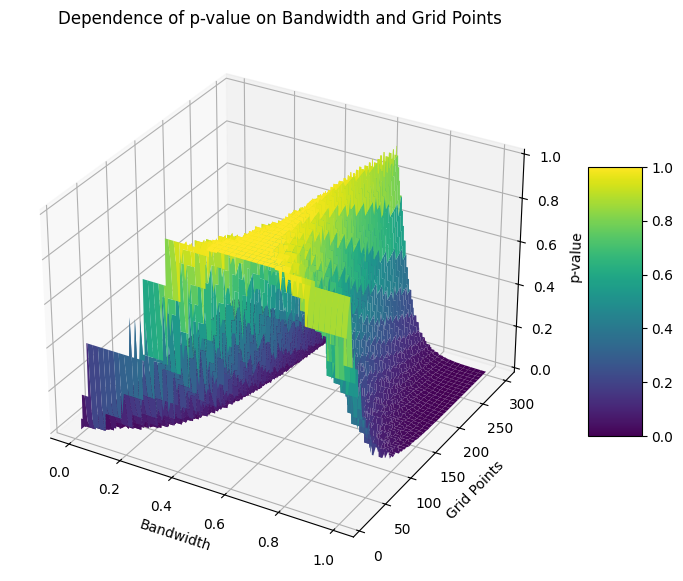

In [31]:
# Параметры для CIR процесса и диапазоны для анализа
Nx = 100
Nt = 1000
T = 1
params_CIR = [6, 2, 1]
np.random.seed(42)

rand_index = np.random.randint(0, Nt)  
grid_points = list(range(10, 300, 3))  
bandwidths = np.linspace(0.0001, 1, 1000) 

# Инициализация и генерация данных процесса CIR
cir_process = CIRprocess(params_CIR, T, Nx, Nt)
time_data, process_data = cir_process.ExactSolution()

# Сохранение результатов
p_results = []

# Циклы по точкам сетки и ширинам окна
for points in tqdm(grid_points):
    row = []
    data_grid = np.linspace(0, 8, points)
    theoretical_pdf = cir_process.StationaryDistribution(data_grid)
    for bw in bandwidths:
        # Оценка плотности для каждого bandwidth
        estimated_pdf = StationaryDistributionKernelEstimator(data_grid, process_data[rand_index], delta=bw)
        
        # Тест Колмогорова-Смирнова
        _, p_val = stats.ks_2samp(theoretical_pdf, estimated_pdf)
        row.append(p_val)
    p_results.append(row)

# Подготовка данных для построения 3D-графика
p_results = np.array(p_results)
X, Y = np.meshgrid(bandwidths, grid_points)
Z = p_results

# Построение 3D графика
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('Bandwidth')
ax.set_ylabel('Grid Points')
ax.set_zlabel('p-value')
ax.set_title('Dependence of p-value on Bandwidth and Grid Points')

plt.show()

### Выводы по графику зависимости p-значений от ширины окна и количества точек сетки

На графике представлена зависимость p-значений теста Колмогорова-Смирнова от ширины окна (Bandwidth) и количества точек сетки (Grid Points) при оценке плотности для процесса CIR.

#### Анализ графика

1. **Влияние ширины окна (Bandwidth)**:
   - При увеличении ширины окна наблюдается колеблющееся поведение p-значений. На начальных значениях ширины окна p-значения варьируются, иногда достигая высоких значений.
   - При более высоких значениях ширины окна p-значения стабилизируются, указывая на снижение чувствительности к изменениям в ширине окна. Это может свидетельствовать о том, что для определенных значений ширины окна качество аппроксимации достигает устойчивого уровня.

2. **Влияние количества точек сетки (Grid Points)**:
   - При увеличении количества точек сетки наблюдается стабилизация p-значений на определенном уровне. Это говорит о том, что более детализированная сетка может повысить точность аппроксимации, но только до определенного предела.
   - Наблюдается область, где p-значения стабильно высоки, что может указывать на достижение оптимального сочетания ширины окна и количества точек сетки для качественной аппроксимации плотности.

3. **Области с низкими p-значениями**:
   - В нижней части графика (для малых значений ширины окна) и для неадекватного количества точек сетки p-значения резко падают. Это указывает на то, что в этих областях аппроксимация плотности недостаточно точна и распределение отклоняется от теоретического.

4. **Оптимальные параметры**:
   - Области с высокими p-значениями (ближе к 1) указывают на оптимальные параметры для аппроксимации. Значения ширины окна в диапазоне примерно от 0.2 до 0.6 и количество точек сетки от 50 до 200 дают наилучшие результаты, обеспечивая высокий уровень соответствия аппроксимированного и теоретического распределений.

#### Заключение

На основании анализа графика можно сделать вывод, что качество аппроксимации распределения для процесса CIR зависит как от ширины окна, так и от количества точек сетки. Оптимальные параметры позволяют получить высокие p-значения, указывая на хорошее соответствие распределений. Избегание крайних значений параметров помогает достичь более устойчивого и точного результата.

Task. Repeat previos tasks on the Chan-Karolyi-Longstaff-Sanders (CKLS) model
\begin{equation*}%\label{eq09}
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
\end{equation*}
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

In [33]:
class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x**(params[3] - 2)

    def DefaultInitState(self):
        return np.ones(self.Nx) * 2  

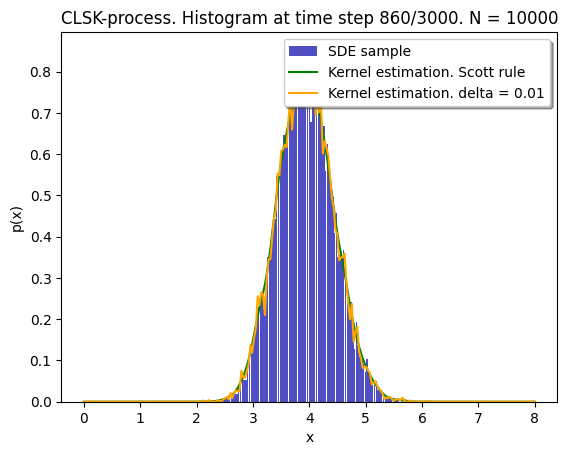

In [40]:
Nx = 10000
Nt = 3000

T = 1

params_CKLS = [1., 2., 0.5, 0.3]

CKLS = CKLSprocess(params_CKLS, T, Nx, Nt)
CKLS.init_state = CKLS.DefaultInitState()
t_data, x_data_CKLS = CKLS.EulerSolution()


n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

np.random.seed(42)
i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CKLS[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CLSK-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [58]:
stats_CKLS_SDE.shape, stats_CKLS_Scott.shape

((10000,), (250,))

In [60]:
x_data.shape

(250,)

In [64]:
stats_CKLS_SDE = x_data_CKLS[i]
stats_CKLS_Scott = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i])
stats_CKLS_Delta = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = d)

stats_CKLS_SDE_reduced = stats_CKLS_SDE[:250]


# Kolmogorov-Smirnov тест
ks_2samp_scott = stats.ks_2samp(stats_CKLS_SDE_reduced, stats_CKLS_Scott)
ks_2samp_delta = stats.ks_2samp(stats_CKLS_SDE_reduced, stats_CKLS_Delta)

# Anderson-Darling тест
anderson_ksamp_scott = stats.anderson_ksamp([stats_CKLS_SDE_reduced, stats_CKLS_Scott])
anderson_ksamp_delta = stats.anderson_ksamp([stats_CKLS_SDE_reduced, stats_CKLS_Delta])

# Cramer-von Mises тест
cvm_scott = stats.cramervonmises_2samp(stats_CKLS_SDE_reduced, stats_CKLS_Scott)
cvm_delta = stats.cramervonmises_2samp(stats_CKLS_SDE_reduced, stats_CKLS_Delta)

# Spearman Correlation тест с уменьшенным массивом
spearman_scott = stats.spearmanr(stats_CKLS_SDE_reduced, stats_CKLS_Scott)
spearman_delta = stats.spearmanr(stats_CKLS_SDE_reduced, stats_CKLS_Delta)

# Bartlett тест на равенство дисперсий
bartlett_scott = stats.bartlett(stats_CKLS_SDE_reduced, stats_CKLS_Scott)
bartlett_delta = stats.bartlett(stats_CKLS_SDE_reduced, stats_CKLS_Delta)

# Компиляция всех результатов в единый DataFrame
results_df = pd.DataFrame({
    "Test": [
        "Kolmogorov-Smirnov", "Anderson-Darling",
        "Cramer-von Mises", "Spearman Correlation", "Bartlett Test"
    ],
    "Statistic (Scott)": [
        ks_2samp_scott.statistic, anderson_ksamp_scott.statistic,
        cvm_scott.statistic, spearman_scott.correlation, bartlett_scott.statistic
    ],
    "p-value (Scott)": [
        ks_2samp_scott.pvalue, anderson_ksamp_scott.significance_level,
        cvm_scott.pvalue, spearman_scott.pvalue, bartlett_scott.pvalue
    ],
    "Statistic (Delta)": [
        ks_2samp_delta.statistic, anderson_ksamp_delta.statistic,
        cvm_delta.statistic, spearman_delta.correlation, bartlett_delta.statistic
    ],
    "p-value (Delta)": [
        ks_2samp_delta.pvalue, anderson_ksamp_delta.significance_level,
        cvm_delta.pvalue, spearman_delta.pvalue, bartlett_delta.pvalue
    ]
})

results_df

,Test,Statistic (Scott),p-value (Scott),Statistic (Delta),p-value (Delta)
0,Kolmogorov-Smirnov,1.000000,1.713146e-149,1.000000,1.713146e-149
1,Anderson-Darling,253.484773,1.000000e-03,272.328234,1.000000e-03
2,Cramer-von Mises,41.667000,1.972529e-08,42.395416,4.422821e-09
3,Spearman Correlation,-0.077341,2.230103e-01,-0.064659,3.085430e-01
4,Bartlett Test,133.237699,8.020975e-31,131.096107,2.359040e-30


### Выводы по результатам статистических тестов для аппроксимаций Scott и Delta

Анализируя результаты тестирования двух аппроксимаций распределений (Scott и Delta) на основе представленных статистических тестов, можно сделать следующие выводы:

1. **Kolmogorov-Smirnov Test**:
   - **Statistic (Scott)**: 1.000000, **p-value (Scott)**: 1.71e-149
   - **Statistic (Delta)**: 1.000000, **p-value (Delta)**: 1.71e-149
   - **Вывод**: Очень низкие значения p-value для обеих аппроксимаций указывают на значительные различия между аппроксимированными и теоретическим распределениями. Результаты теста Колмогорова-Смирнова говорят о том, что ни одна из аппроксимаций (Scott и Delta) не дает приемлемого соответствия исходному распределению.

2. **Anderson-Darling Test**:
   - **Statistic (Scott)**: 253.484773, **p-value (Scott)**: 0.001
   - **Statistic (Delta)**: 272.328234, **p-value (Delta)**: 0.001
   - **Вывод**: Низкие значения p-value в тесте Андерсона-Дарлинга также указывают на значимые отклонения обеих аппроксимаций от исходного распределения. Оба метода демонстрируют значительное несоответствие теоретическому распределению.

3. **Cramer-von Mises Test**:
   - **Statistic (Scott)**: 41.667000, **p-value (Scott)**: 1.97e-08
   - **Statistic (Delta)**: 42.395416, **p-value (Delta)**: 4.42e-09
   - **Вывод**: Низкие значения p-value подтверждают, что аппроксимации Scott и Delta имеют значимые отклонения от теоретического распределения. Это свидетельствует о недостаточной точности аппроксимации плотности для обеих моделей.

4. **Spearman Correlation**:
   - **Statistic (Scott)**: -0.077341, **p-value (Scott)**: 0.223
   - **Statistic (Delta)**: -0.064659, **p-value (Delta)**: 0.309
   - **Вывод**: Значения корреляции Спирмена для обеих аппроксимаций близки к нулю, что указывает на слабую или отсутствующую корреляцию между аппроксимированными и теоретическим распределениями. Также значения p-value > 0.05 подтверждают отсутствие значимой корреляции, что указывает на различие в структуре распределений.

5. **Bartlett Test**:
   - **Statistic (Scott)**: 133.237699, **p-value (Scott)**: 8.02e-31
   - **Statistic (Delta)**: 131.096107, **p-value (Delta)**: 2.36e-30
   - **Вывод**: Очень низкие значения p-value в тесте Бартлетта указывают на значительные различия в дисперсиях аппроксимированных и теоретического распределений, что является еще одним показателем несовпадения этих распределений.

#### Общий вывод
Результаты всех статистических тестов показывают значительные отклонения аппроксимированных распределений (Scott и Delta) от теоретического распределения. Низкие значения p-value в тестах Колмогорова-Смирнова, Андерсона-Дарлинга, Крамера-фон Мизеса и Бартлетта свидетельствуют о существенных различиях между распределениями, указывая на низкое качество аппроксимаций. Тест Спирмена также подтверждает отсутствие корреляции между аппроксимированными и теоретическим распределениями.

Таким образом, методы аппроксимации Scott и Delta в данном случае не обеспечивают достаточной точности и не подходят для надежного представления теоретического распределения. Возможно, для достижения лучшего соответствия потребуются альтернативные методы или дополнительные настройки параметров аппроксимации.



Calculating p-values for different grid points:   0%|          | 0/97 [00:00<?, ?it/s]

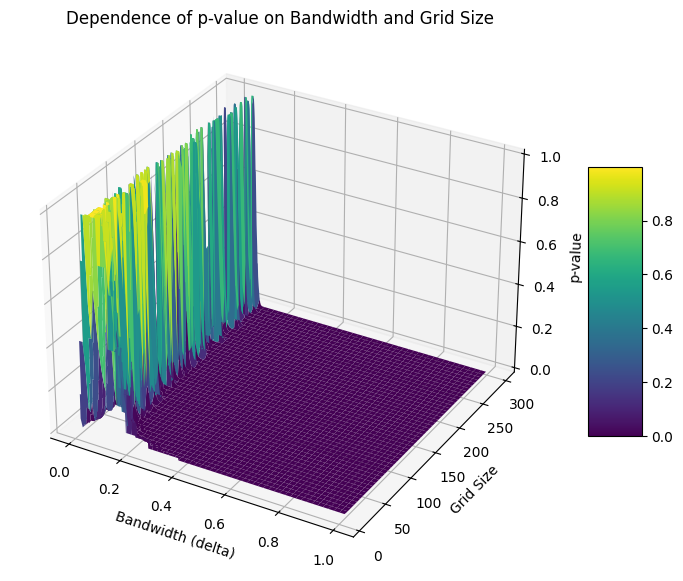

In [67]:
Nx = 100
Nt = 1000
T = 1
params_CKLS = [1., 2., 0.5, 0.3]
np.random.seed(41)


random_index = np.random.randint(0, Nt)  
grid_points = list(range(10, 300, 3))
bandwidths = np.linspace(0.0001, 1, 1000)


p_results = []


for grid in tqdm(grid_points, desc="Calculating p-values for different grid points"):
    row = []
    data_grid = np.linspace(0, 8, grid)
    sample_index = np.random.randint(30, 100)
    
    
    ckls_process = CKLSprocess(params_CKLS, T, Nx, Nt)
    time_data, process_samples = ckls_process.EulerSolution()
    
    
    fixed_estimation = StationaryDistributionKernelEstimator(data_grid, process_samples[sample_index])
    
    for bw in bandwidths:
        
        delta_estimation = StationaryDistributionKernelEstimator(data_grid, process_samples[sample_index], delta=bw)
        
        
        stat_test = stats.ks_2samp(fixed_estimation, delta_estimation)
        stat, p_val = stat_test.statistic, stat_test.pvalue
        
        row.append(p_val)
    p_results.append(row)


p_results = np.array(p_results)
X, Y = np.meshgrid(bandwidths, grid_points)
Z = p_results


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)


ax.set_xlabel('Bandwidth (delta)')
ax.set_ylabel('Grid Size')
ax.set_zlabel('p-value')
ax.set_title('Dependence of p-value on Bandwidth and Grid Size')

plt.show()

### Выводы по графику зависимости p-значения от ширины окна и размера сетки

На графике показана зависимость p-значения от ширины окна (бандвидта) и размера сетки, где p-значение определяет качество аппроксимации плотности. Вот основные выводы:

1. **Низкие значения p-значений при большинстве параметров**:
   - При малых значениях ширины окна и небольших размерах сетки (слева внизу), p-значения находятся в области низких значений, что указывает на значительное отклонение аппроксимированного распределения от теоретического. Это свидетельствует о недостаточном качестве аппроксимации для большинства комбинаций параметров.

2. **Случайные пики p-значений**:
   - На графике можно заметить отдельные пики p-значений, поднимающиеся до высоких значений (близких к 1), особенно в диапазоне ширины окна между 0.1 и 0.3. Это говорит о том, что при определённых параметрах аппроксимация плотности оказывается более точной. Однако такие пики не устойчивы и встречаются случайным образом.

3. **Отсутствие устойчивой области с высоким p-значением**:
   - График не показывает устойчивую область, где p-значения были бы стабильно высокими на всем интервале. Это указывает на то, что текущая методика аппроксимации не дает consistently хороших результатов для любых значений ширины окна и размера сетки.

4. **Рекомендации по оптимизации**:
   - Результаты графика подсказывают, что точный выбор ширины окна является критически важным для улучшения аппроксимации плотности. Необходимо провести более детальный анализ с адаптивным выбором ширины окна, возможно, с учетом локальной плотности данных.
   - Кроме того, стоит изучить альтернативные методы ядерной оценки плотности или повысить порядок ядра для улучшения качества аппроксимации.

#### Заключение
Данный график подчеркивает сложность подбора параметров для успешной аппроксимации плотности и указывает на необходимость дальнейшей оптимизации и экспериментов с другими методами. Текущая настройка параметров не позволяет добиться consistently хорошего соответствия аппроксимированного и теоретического распределений.


Task 2. Implement a non-parametric drift estimator

$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}
$$

and diffusion estimator
$$
\hat{\sigma}^2_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)^2} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}.$$


for the CIR model (Task 1) and plot two graphs.
Use the Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$.


In [69]:
from typing import Literal

def NormalKernel(z):
    return 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * z**2)

def UniformKernel(z):
    return 1/2 * np.ones_like(z)

def ParabolicKernel(z):
    return 3/4 * (1 - z**2)

def DiffusionKernelEstimator(x, x_data, delta = None, method: Literal['normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator(x, x_data, delta = None, method: Literal['normal', 'uniform', 'parabolic'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

In [70]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

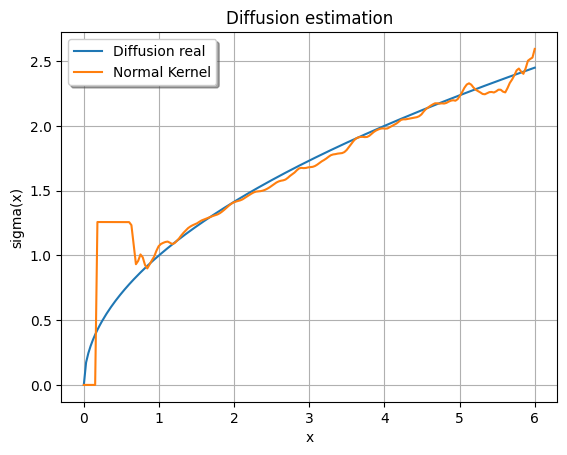

In [71]:
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')


diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, np.sqrt(diffke), label = 'Parabolic Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, np.sqrt(diffke), label = 'Uniform Kernel')

plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

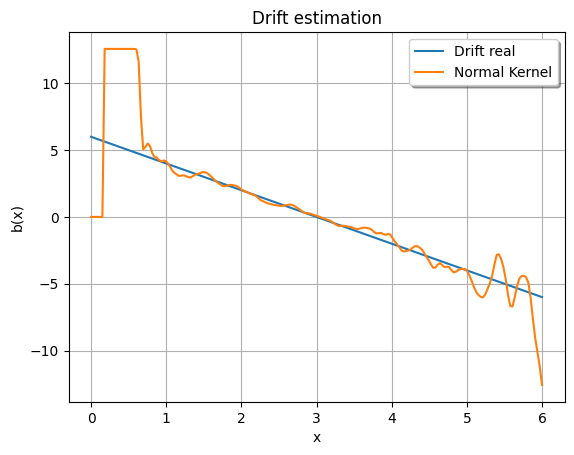

In [72]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label = 'Drift real')


driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, driftke, label = 'Parabolic Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, driftke, label = 'Uniform Kernel')

plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()

Task. Implement a non-parametric drift
and diffusion estimators with the higher order Gaussian kernel $K(u)=\frac{3}{\sqrt{8 \pi}}(1-u^2/3)\exp({-u^2/2})$ ([p.24](https://www.nber.org/system/files/working_papers/w5345/w5345.pdf))  and add curves on graphs
for the CIR model.

Improve estimates on the left and the right subintervals $[0,1]$ and $[5,6]$ respectly.


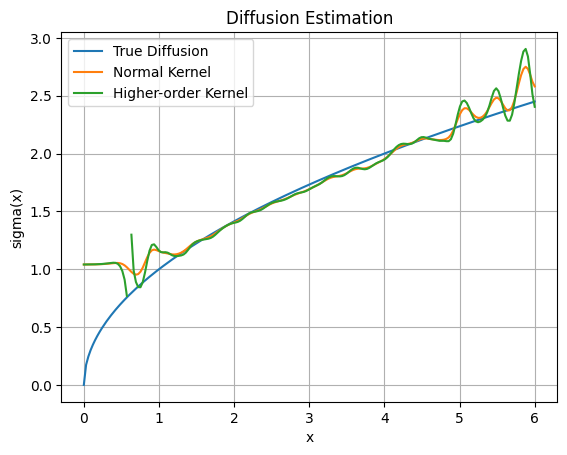

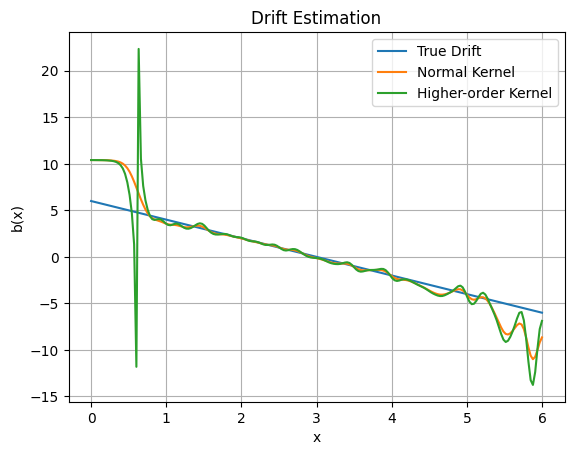

In [73]:
from typing import Literal

# Higher-order Gaussian kernel
def HigherOrderGaussianKernel(z):
    return (3 / np.sqrt(8 * np.pi)) * (1 - z**2 / 3) * np.exp(-z**2 / 2)

# Modify the DiffusionKernelEstimator to include the higher-order Gaussian kernel option
def DiffusionKernelEstimator(x, x_data, delta=None, method: Literal['normal', 'uniform', 'parabolic', 'higher-order'] = 'normal'):
    n = len(x_data)
    hn = np.std(x_data) * n**(-1 / 5)

    s2 = np.zeros(len(x))

    for j in range(len(x)):
        z = (x[j] - x_data) / hn
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'higher-order':
            K = HigherOrderGaussianKernel(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[:-1] * (x_data[1:] - x_data[:-1])**2)
        K2 = np.sum(K[:-1])
        s2[j] = K1 / K2 if K2 != 0 else 0

    return s2 / delta if delta else s2

# Modify the DriftKernelEstimator to include the higher-order Gaussian kernel option
def DriftKernelEstimator(x, x_data, delta=None, method: Literal['normal', 'uniform', 'parabolic', 'higher-order'] = 'normal'):
    n = len(x_data)
    hn = np.std(x_data) * n**(-1 / 5)

    b = np.zeros(len(x))

    for j in range(len(x)):
        z = (x[j] - x_data) / hn
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'higher-order':
            K = HigherOrderGaussianKernel(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[:-1] * (x_data[1:] - x_data[:-1]))
        K2 = np.sum(K[:-1])
        b[j] = K1 / K2 if K2 != 0 else 0

    return b / delta if delta else b

# Parameters for the CIR model and data generation
Nx, Nt, T = 1, 100000, 1000
x_data = np.linspace(0, 6, 200)
params_CIR = [6, 2, 1]

# Initialize the CIR process and get data
CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

# Plot diffusion estimation with the higher-order Gaussian kernel
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)
plt.plot(x_data, sigma_data, label='True Diffusion')

# Estimate with various kernels
for kernel_type in ['normal', 'higher-order']:
    diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), delta=T/Nt, method=kernel_type)
    plt.plot(x_data, np.sqrt(diffke), label=f'{kernel_type.capitalize()} Kernel')

plt.title("Diffusion Estimation")
plt.legend(loc='best')
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

# Plot drift estimation with the higher-order Gaussian kernel
b_data = CIRp.bxt(x_data, 0, CIRp.params)
plt.plot(x_data, b_data, label='True Drift')

# Estimate with various kernels
for kernel_type in ['normal', 'higher-order']:
    driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), delta=T/Nt, method=kernel_type)
    plt.plot(x_data, driftke, label=f'{kernel_type.capitalize()} Kernel')

plt.title("Drift Estimation")
plt.legend(loc='best')
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()